In [1]:
import dask.dataframe as dd
import pandas as pd
import os
import csv
import traceback
import logging
import numpy as np
import geopandas as gp
import scipy.stats as st
service_time_map = {}
source_df = pd.read_csv("/home/blakemoss/911_modeling/ts_data_map.csv")

In [2]:
data_map = source_df.dropna(subset=['first_unit_tohospital', 'first_unit_athospital'])
for index, row in data_map.iterrows():
    print(row['Dataset'])
    dataset_path = "/home/blakemoss/911_modeling/data_retrieval/csvs/{}".format(row['Dataset'])
    filename = row['Dataset']
    columns = [row['first_unit_tohospital'], row['first_unit_athospital'], row['unique_id']]
    c = columns[0]
    d = columns[1]
    unique_id = columns[2]
    df = dd.read_csv(dataset_path, usecols=columns)
    df = df.dropna()
    df = df.compute()
    df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    df[d] = pd.to_datetime(df[d], errors="coerce", infer_datetime_format=True)
    df = df.sort_values(by=c,ascending=True)
    df['service_time'] = (df[d]-df[c]).dt.seconds.fillna(np.float64(0))
    df = df[df['service_time']!= np.float64(0)]
    df.index = df[c]
    day_watch = df.between_time('07:00','15:00')
    swing_watch = df.between_time('15:00','23:00')
    midnight_watch = df.between_time('23:00','07:00')
    service_time_map[filename] = {"day (7AM-3PM)": day_watch['service_time'].values, "swing (3PM-11:PM)": swing_watch['service_time'].values, "midnight (11PM-7AM)": midnight_watch['service_time'].values, "All": df['service_time'].values}


nyc_ems_2019.csv
first_unit_sf_fire_2019.csv


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [7]:
def plot_service_histogram(name, obj):
    for shift, count in obj.items():
        e = st.expon
        args = e.fit(count)
        t = [x for x in range(int(max(count)))]
        #t = st.iqr(count)
        #print(t)
        fig, ax = plt.subplots()
        #ax.boxplot(count)
        n, bins, patches = ax.hist(count, bins=len(t), density=True)
        x = [a for a in range(int(bins[-1]))]
        y = e.pdf(x, *args)
        ax.plot(x,y,'k')
        ax.set_title("Service Time Histogram {}, {} ({})".format(name, shift, args))
        ax.set_xlabel("# Elapsed Time between timestamps (Buckets)")
        ax.set_ylabel("Probability")

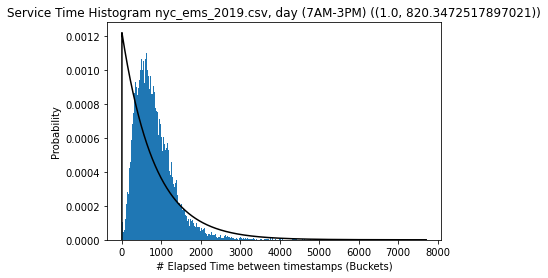

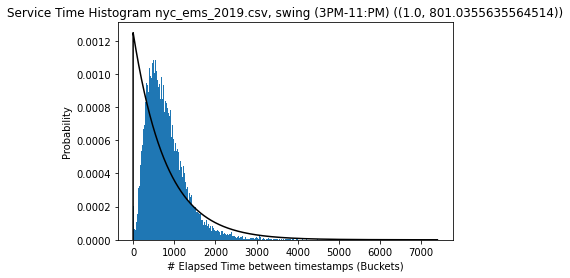

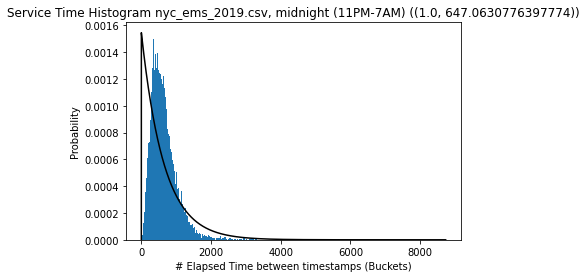

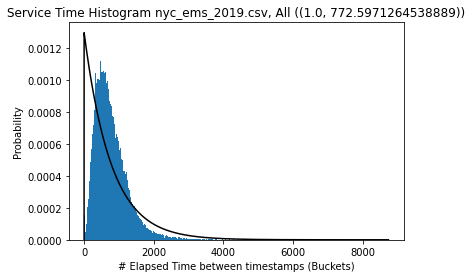

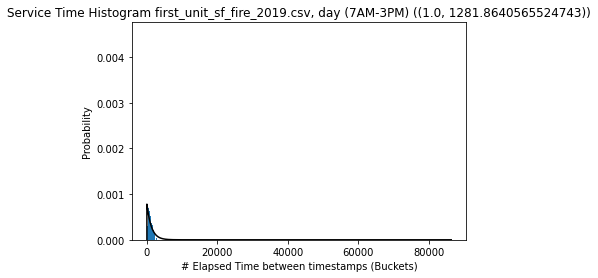

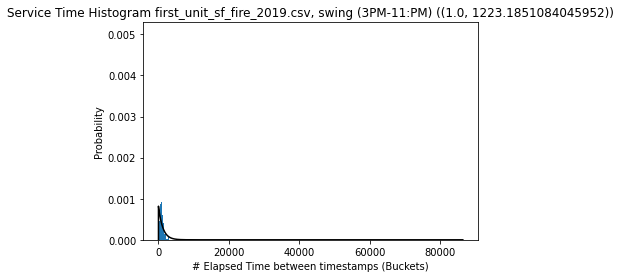

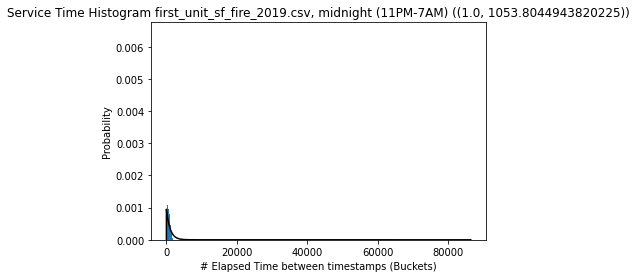

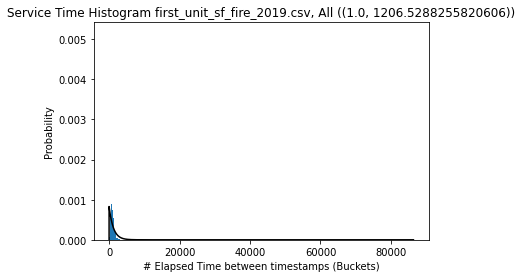

In [8]:
for name, obj in service_time_map.items():
    plot_service_histogram(name, obj)
